Importing Libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import os
import random
import numpy as np
from PIL import Image

Tp Disable this Warning \
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

Labels

In [3]:
class_label_real = 0
class_label_attack = 1

RA_Dataset_Train_Test Distribution:

A. Real Attack -> RA : 150 +200 samples \
B. Real Bonafide -> RB: 60 + 80 samples \
C. Fake Attack -> FA: 60 + 80 samples \
D. Fake Bonafide -> FB: 150 + 200 samples

RM_Dataset_Combined Train/Test Distribution:

A. Real Attack -> RA : 192 + 192 samples \
B. Real Bonafide -> RB: 120 + 110 samples \
C. Fake Attack -> FA: 120 + 110 samples \
D. Fake Bonafide -> FB: 192 + 192 samples

OULU-NPU_Dataset_Combined Train/Test Distribution:

A. Real Attack -> RA : 1440 + 1440 samples \
B. Real Bonafide -> RB: 360 + 360 samples \
C. Fake Attack -> FA: 360 + 360 samples \
D. Fake Bonafide -> FB: 1440 + 1440 samples

RY_Dataset_Combined Train/Test Distribution:

A. Real Attack -> RA : 1039 + 1299 samples \
B. Real Bonafide -> RB: 358 + 449 samples \
C. Fake Attack -> FA: 358 + 449 samples \
D. Fake Bonafide -> FB: 1039 + 1299 samples

Dataset Images Path

In [4]:
train_data_path_real_attack = '/train_samples/real_attack'
test_data_path_real_attack = '/test_samples/real_attack'

train_data_path_real_bonafide = '/train_samples/real_bonafide'
test_data_path_real_bonafide = '/test_samples/real_bonafide'

train_data_path_fake_attack = '/train_samples/fake_attack'
test_data_path_fake_attack = '/test_samples/fake_attack'

train_data_path_fake_bonafide = '/train_samples/fake_bonafide'
test_data_path_fake_bonafide = '/test_samples/fake_bonafide'

Function for Loading Images

In [5]:
def load_samples_image(image_path, class_label, transform):
    image = Image.open(image_path).convert('RGB') # It uses PIL (Pillow) library to open the image, convert it to the RGB mode
    sample = (transform(image), class_label) # Apply transformation
    return sample

class ImageDataset(Dataset):
    def __init__(self, data_path, class_label):
        self.data_path = data_path
        self.image_files = [file for file in os.listdir(data_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
        self.class_label = class_label
        self.data_length = len(self.image_files)
        self.transform = transforms.Compose([transforms.Resize((256, 256)),
                                             transforms.ToTensor()])

    def __len__(self):
        return self.data_length

    def __getitem__(self, idx):
        file = self.image_files[idx]
        path = os.path.join(self.data_path, file)
        sample = load_samples_image(path, self.class_label, self.transform)
        return sample

Loading Dataset & Assigning Labels

In [6]:
train_real_attack = ImageDataset(train_data_path_real_attack, class_label_attack)
test_real_attack = ImageDataset(test_data_path_real_attack, class_label_attack)

train_real_bonafide = ImageDataset(train_data_path_real_bonafide, class_label_real)
test_real_bonafide = ImageDataset(test_data_path_real_bonafide, class_label_real)

train_fake_attack = ImageDataset(train_data_path_fake_attack, class_label_attack)
test_fake_attack = ImageDataset(test_data_path_fake_attack, class_label_attack)

train_fake_bonafide = ImageDataset(train_data_path_fake_bonafide, class_label_attack)
test_fake_bonafide = ImageDataset(test_data_path_fake_bonafide, class_label_attack)

Checking Number of Samples

In [7]:
print("Total No of Train Real Attack Samples:", len(train_real_attack))
print("Total No of Test Real Attack Samples:", len(test_real_attack))
print("Total No of Train Real Bonafide Samples:", len(train_real_bonafide))
print("Total No of Test Real Bonafide Samples:", len(test_real_bonafide))
print("Total No of Train Fake Attack Samples:", len(train_fake_attack))
print("Total No of Test Fake Attack Samples:", len(test_fake_attack))
print("Total No of Train Fake Bonafide Samples:", len(train_fake_bonafide))
print("Total No of Test Fake Bonafide Samples:", len(test_fake_bonafide))

Total No of Train Real Attack Samples: 1440
Total No of Test Real Attack Samples: 1440
Total No of Train Real Bonafide Samples: 360
Total No of Test Real Bonafide Samples: 360
Total No of Train Fake Attack Samples: 360
Total No of Test Fake Attack Samples: 360
Total No of Train Fake Bonafide Samples: 1440
Total No of Test Fake Bonafide Samples: 1440


Concatenated Distributions

In [8]:
concatenated_distribution = ConcatDataset([train_real_attack, test_real_attack, train_real_bonafide, test_real_bonafide, train_fake_attack, test_fake_attack, train_fake_bonafide, test_fake_bonafide])

In [9]:
print(len(concatenated_distribution))

7200


Loading Concatenated Distribution

In [10]:
concatenated_distribution_loader = DataLoader(concatenated_distribution, batch_size=64, shuffle=False)

For Image Domain

In [11]:
concatenated_samples = torch.empty(0, 196608)
concatenated_labels = torch.empty(0, dtype=torch.int64)

for samples, labels in concatenated_distribution_loader:
    reshape_samples = samples.view(samples.size(0), -1)  # Flatten to 2D [64, 3, 256, 256] to [64, 196608]
    concatenated_samples = torch.cat((concatenated_samples, reshape_samples), dim=0)
    concatenated_labels = torch.cat((concatenated_labels, labels))

In [12]:
print(concatenated_samples.shape)
print(concatenated_labels)

torch.Size([7200, 196608])
tensor([1, 1, 1,  ..., 1, 1, 1])


For Pre-Adversarial Training Feature Space and Post-Adversarial Training Feature Space

In [ ]:
# Define the path to your saved before adversarial training and after adversarial training model file

model_path = '/best_model.pth'

# Load the saved model
checkpoint = torch.load(model_path)

# Load the model's state dictionary
model.load_state_dict(checkpoint)

In [ ]:
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
print(feature_extractor)

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, m

In [ ]:
model.eval()
with torch.no_grad():
    concatenated_samples = torch.empty(0, 1280)
    concatenated_labels = torch.empty(0, dtype=torch.int64)

    for samples, labels in concatenated_distribution_loader:
        
        samples_fe = feature_extractor(samples)
        samples_fe = torch.nn.functional.adaptive_avg_pool2d(samples_fe, (1, 1))  # Global average pooling
        reshape_samples = samples_fe.view(samples_fe.size(0), -1)  # Flatten to 2D [64, 1280, 1, 1] to [64, 1280]
        concatenated_samples = torch.cat((concatenated_samples, reshape_samples), dim=0)
        concatenated_labels = torch.cat((concatenated_labels, labels))

In [ ]:
print(concatenated_samples.shape)
print(concatenated_labels)

torch.Size([7200, 1280])
tensor([1, 1, 1,  ..., 1, 1, 1])


Applying TSNE

In [13]:
#Using tsne (t-distributed stochastic neighbor embedding) -> used for dimension reduction
from sklearn.manifold import TSNE
#Apply t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42) #42 good universe number, by keeping random_state= Anynumber (same), across multiple runs, you will get the same results, if you choose different seed, the results will different
reduced_data = tsne.fit_transform(concatenated_samples)
print(reduced_data.shape)

(7200, 2)


In [14]:
# Split the reduced data back into separate distributions
train_reduced_distribution_1 = reduced_data[0:len(train_real_attack)]
test_reduced_distribution_1 = reduced_data[len(train_real_attack):len(train_real_attack)+len(test_real_attack)]


train_reduced_distribution_2 = reduced_data[len(train_real_attack)+len(test_real_attack):len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)]
test_reduced_distribution_2 = reduced_data[len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide):len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)+len(test_real_bonafide)]


train_reduced_distribution_3 = reduced_data[len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)+len(test_real_bonafide):len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)+len(test_real_bonafide)+len(train_fake_attack)] 
test_reduced_distribution_3 = reduced_data[len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)+len(test_real_bonafide)+len(train_fake_attack):len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)+len(test_real_bonafide)+len(train_fake_attack)+len(test_fake_attack)] 


train_reduced_distribution_4 = reduced_data[len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)+len(test_real_bonafide)+len(train_fake_attack)+len(test_fake_attack):len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)+len(test_real_bonafide)+len(train_fake_attack)+len(test_fake_attack)+len(train_fake_bonafide)]
test_reduced_distribution_4 = reduced_data[len(train_real_attack)+len(test_real_attack)+len(train_real_bonafide)+len(test_real_bonafide)+len(train_fake_attack)+len(test_fake_attack)+len(train_fake_bonafide):]

List of Colors

'red', 'orange', 'green', 'cyan', 'brown', 'purple', 'olive', 'blue'

TSNE Plot

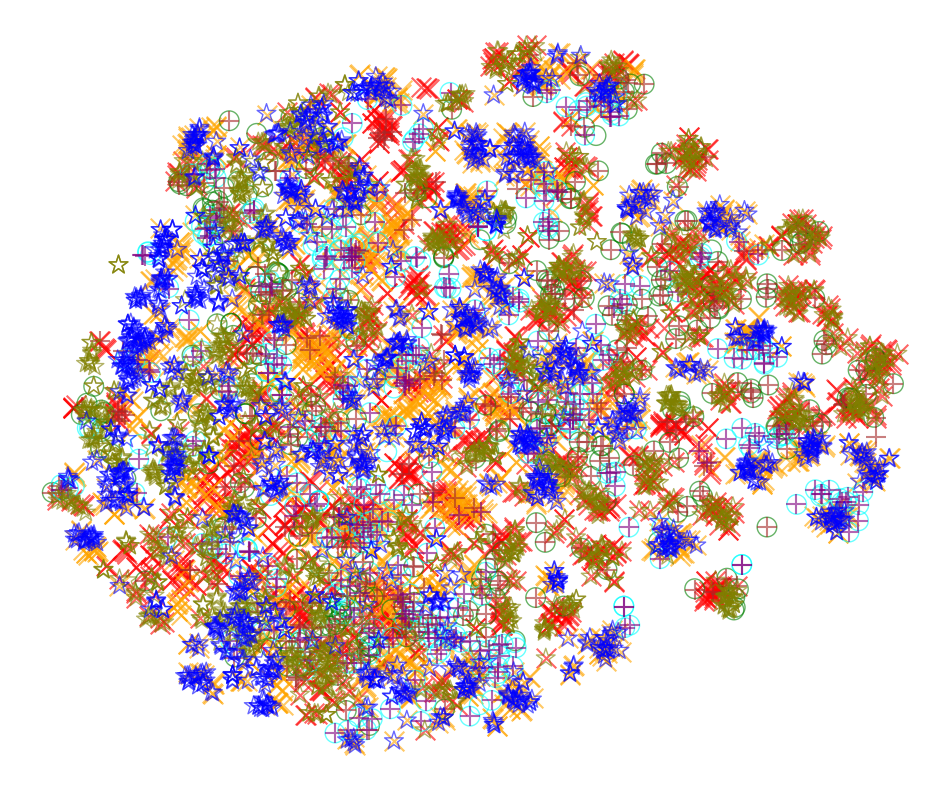

In [54]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 10))  # Increase the figure size for better visibility

marker_size = 200  # Adjust the marker size as needed

# Plot reduced distribution 1
plt.scatter(train_reduced_distribution_1[:, 0], train_reduced_distribution_1[:, 1], label='train_attack', c='red', marker='x', alpha=0.6, s=marker_size)
plt.scatter(test_reduced_distribution_1[:, 0], test_reduced_distribution_1[:, 1], label='test_attack', c='orange', marker='x', alpha=0.6, s=marker_size)

# Plot reduced distribution 2
plt.scatter(train_reduced_distribution_2[:, 0], train_reduced_distribution_2[:, 1], label='train_bon', edgecolors='green', facecolors='none', marker='o', alpha=0.6, s=marker_size)
plt.scatter(test_reduced_distribution_2[:, 0], test_reduced_distribution_2[:, 1], label='test_bon', edgecolors='cyan', facecolors='none', marker='o', alpha=0.6, s=marker_size)

# Plot reduced distribution 3
plt.scatter(train_reduced_distribution_3[:, 0], train_reduced_distribution_3[:, 1], label='train_fa', c='brown', marker='+', alpha=0.6, s=marker_size)
plt.scatter(test_reduced_distribution_3[:, 0], test_reduced_distribution_3[:, 1], label='test_fa', c='purple', marker='+', alpha=0.6, s=marker_size)

# Plot reduced distribution 4
plt.scatter(train_reduced_distribution_4[:, 0], train_reduced_distribution_4[:, 1], label='train_fb', edgecolors='olive', facecolors='none', marker='*', alpha=0.6, s=marker_size)
plt.scatter(test_reduced_distribution_4[:, 0], test_reduced_distribution_4[:, 1], label='test_fb', edgecolors='blue', facecolors='none', marker='*', alpha=0.6, s=marker_size)


# Remove x and y axis scales
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
# Remove the border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Save the figure
plt.savefig('name_TSNE.png', bbox_inches='tight', transparent=True)

plt.show()

Save Markers as Individual Figure with Marker Size Control

In [ ]:
# Create the main plot
fig, ax = plt.subplots(figsize=(8, 6))  # Increase the figure size for better visibility

# Plot reduced distribution 1
scatter1 = ax.scatter(train_reduced_distribution_1[:, 0], train_reduced_distribution_1[:, 1], label='Train Real Attack', c='red', marker='x', alpha=0.6)
scatter2 = ax.scatter(test_reduced_distribution_1[:, 0], test_reduced_distribution_1[:, 1], label='Test Real Attack', c='orange', marker='x', alpha=0.6)

# Plot reduced distribution 2
scatter3 = ax.scatter(train_reduced_distribution_2[:, 0], train_reduced_distribution_2[:, 1], label='Train Real Bonafide', edgecolors='green', facecolors='none', marker='o', alpha=0.6)
scatter4 = ax.scatter(test_reduced_distribution_2[:, 0], test_reduced_distribution_2[:, 1], label='Test Real Bonafide', edgecolors='cyan', facecolors='none', marker='o', alpha=0.6)

# Plot reduced distribution 3
scatter5 = ax.scatter(train_reduced_distribution_3[:, 0], train_reduced_distribution_3[:, 1], label='Train Fake Attack', c='brown', marker='+', alpha=0.6)
scatter6 = ax.scatter(test_reduced_distribution_3[:, 0], test_reduced_distribution_3[:, 1], label='Test Fake Attack', c='purple', marker='+', alpha=0.6)

# Plot reduced distribution 4
scatter7 = ax.scatter(train_reduced_distribution_4[:, 0], train_reduced_distribution_4[:, 1], label='Train Fake Bonafide', edgecolors='olive', facecolors='none', marker='*', alpha=0.6)
scatter8 = ax.scatter(test_reduced_distribution_4[:, 0], test_reduced_distribution_4[:, 1], label='Test Fake Bonafide', edgecolors='blue', facecolors='none', marker='*', alpha=0.6)

# Remove x and y axis scales
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Remove the border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Save the main plot
plt.savefig('name_TSNE.png', bbox_inches='tight', transparent=True)

# Create a new figure for the legend
fig_legend = plt.figure(figsize=(2, 2))  # Adjust the size as needed
ax_legend = fig_legend.add_subplot(111)
ax_legend.axis('off')
legend = ax_legend.legend(*ax.get_legend_handles_labels(), loc='center', frameon=False)

# Save the legend
fig_legend.savefig('legend_only.png', bbox_inches='tight', transparent=True)

plt.show()

# Save each legend marker as a separate figure with increased size and bolded markers
markers = [scatter1, scatter2, scatter3, scatter4, scatter5, scatter6, scatter7, scatter8]
labels = ['Train Real Attack', 'Test Real Attack', 'Train Real Bonafide', 'Test Real Bonafide', 'Train Fake Attack', 'Test Fake Attack', 'Train Fake Bonafide', 'Test Fake Bonafide']

# Set the increased marker size
marker_size = 800  # Adjust this value to increase the marker size

for marker, label in zip(markers, labels):
    fig, ax = plt.subplots(figsize=(0.7, 0.7))  # Reduced size
    edgecolors = marker.get_edgecolor()
    facecolors = marker.get_facecolor()
    alpha = marker.get_alpha()
    marker_shape = marker.get_paths()[0]

    # Draw a single point to represent the marker with increased size and bold edge
    if edgecolors != 'none':
        ax.scatter([0], [0], s=marker_size, edgecolor=edgecolors, facecolor=facecolors, marker=marker_shape, alpha=alpha, linewidths=3)
    else:
        ax.scatter([0], [0], s=marker_size, color=facecolors, marker=marker_shape, alpha=alpha, linewidths=3)
    
    ax.axis('off')
    fig.savefig(f'{label.replace(" ", "_")}_marker.png', bbox_inches='tight', transparent=True)
    plt.close(fig)